In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from nni.algorithms.compression.pytorch.quantization import LsqQuantizer, QAT_Quantizer

import torch.nn as nn
import onnx
import onnx.numpy_helper
from math import ceil
### markus
import numpy as np
import PIL
import os


import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook

In [24]:
imgSizeY=28
imgSizeY= ceil(imgSizeY/4)*4

imgSizeX=32
imgSizeX= ceil(imgSizeX/4)*4


gen_img_input_dim_x = imgSizeX
gen_img_input_dim_y = imgSizeY
gen_img_input_channels = 3
#test input image
test_input_data="../convertdemo/dataset/mnist2.jpg"
#Paths
quant_image_path = "../quantization_images"
script_path = "../scripts"
log_path = "../logs"
network_path = "../convertdemo/network"
#Files
perform_script = "perform_r6.sh"
parse_script = "parse_r1.sh"
perform_log_file = "model_execution.log"
parsed_log_file = "model_execution_parsed.log"
model_name="mnist"

# Generate images based on some arbitrary input dimension

In [25]:
path = quant_image_path

# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(path)
  print("The new directory quantization_images is created!")

#delete the pre generated bmp/jpg files
filelist = [ f for f in os.listdir(quant_image_path) if (f.endswith(".jpg") or f.endswith(".bmp") ) ]
for f in filelist:
    os.remove(os.path.join(quant_image_path, f))


def generate_random_images(xdim, ydim, channels=3, count=1, path="."):
    """
    This functions generates random bmp images to use for quantization given
    a defined dimension
        @xdim   .. width of images
        @ydim   .. height of images
        @count  .. number of images
        @path   .. path of images
    """
    for c in range(count):
        rnd_img = np.random.randint(low=0,high=255, size=(xdim,ydim,channels),dtype=np.uint8) #imag.transpose((1,2,0)
        imag_tp = np.ascontiguousarray(rnd_img, dtype=np.uint8)

        pil_image = PIL.Image.frombytes('RGB',(xdim,ydim), imag_tp)
        pil_image.save(path + "/rand_"+str(c)+".bmp")
        pil_image.save(path + "/rand_"+str(c)+".jpg")


torch.manual_seed(0)
# choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## generate 10 random input images based on the provided dimensions
generate_random_images(gen_img_input_dim_x, gen_img_input_dim_y, channels=3, count=10, path=quant_image_path)


# Load the Data

In [26]:
torch.manual_seed(0)
# choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Dataloader for MNIST Dataset

resize=(imgSizeX, imgSizeY)
## convert images from 1-color channel to 3-color channel images
#trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,)), transforms.Lambda(lambda x: x.repeat(3, 1, 1) )])
trans = transforms.Compose([transforms.Resize(resize),transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,)), transforms.Lambda(lambda x: x.repeat(3, 1, 1) )])

root='data'
# if not exist, download mnist dataset
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 5

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,)


### Export and view image to test

5 : (3, 32, 28) -> (32, 28, 3)
0 : (3, 32, 28) -> (32, 28, 3)
4 : (3, 32, 28) -> (32, 28, 3)
1 : (3, 32, 28) -> (32, 28, 3)
9 : (3, 32, 28) -> (32, 28, 3)
2 : (3, 32, 28) -> (32, 28, 3)
3 : (3, 32, 28) -> (32, 28, 3)
6 : (3, 32, 28) -> (32, 28, 3)
7 : (3, 32, 28) -> (32, 28, 3)
8 : (3, 32, 28) -> (32, 28, 3)


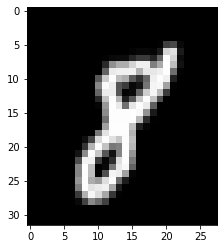

In [27]:
numbers = set()
for i in range(0,100):
    image, label = train_set[i]

    # export until all numbers are present
    if len(numbers)==10:
        break
    if label not in numbers:
        numbers.add(label)
        # denormalize
        imag=(np.array(image.tolist())+0.5) * 255
        # shape image from CHW [RRRRR[..],GGG[...],BBB[...]] -> HWC (3x28x28  -> 28x28x3 [RGB,RGB,RGB,RGB,...])
        imag_tp = np.ascontiguousarray( imag.transpose((1,2,0)), dtype=np.uint8)
        print(f"{label} : {imag.shape} -> {imag_tp.shape}")
       
        #print(imag.shape)
        #print(imag.astype(np.uint8))
        pil_image = PIL.Image.frombytes('RGB',(imgSizeX,imgSizeY), imag_tp)
        #pil_image.save("example_images_rgb\\"+str(label)+".bmp")
        pil_image.save(quant_image_path + "/"+model_name+str(label)+".bmp")
        pil_image.save(quant_image_path + "/"+model_name+str(label)+".jpg")
        
# visualize the last image as example
plt.imshow(imag_tp)

In [28]:
#print(image[:,:,0])
#print( (imag_tp[:,:, 0].astype(float)-127) / 255)

# Build the normal model

In [29]:
# from: https://karanbirchahal.medium.com/how-to-quantise-an-mnist-network-to-8-bits-in-pytorch-no-retraining-required-from-scratch-39f634ac8459
## we want true rgb data to be trained
mnist = False
if mnist:
  num_channels = 1
else:
  num_channels = 3

class Mnist(nn.Module):
    def __init__(self):
        super(Mnist, self).__init__()
        #self.conv1 = nn.Conv2d(num_channels, 20, 5, 1)
        self.conv1 = nn.Conv2d(in_channels = gen_img_input_channels, out_channels = 20, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(20, 20, 5, 1)

        self.conv3 = nn.Conv2d(20, 50, 1, 1)

        f1 = int(imgSizeX/4) - 3
        f2 = int(imgSizeY/4) - 3
        self.fc1 = nn.Linear(f1*f2*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))

        x = F.max_pool2d(x, 2, 2)
        f1 = int(imgSizeX/4) - 3
        f2 = int(imgSizeY/4) - 3
        x = x.view(-1, f1*f2*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [30]:
model = Mnist()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#test
conv1test = nn.Conv2d(in_channels = gen_img_input_channels, out_channels = 20, kernel_size = 5, stride = 1)


# Train the model

In [31]:
def train(model,  device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('{:2.0f}%  Loss {}'.format(100 * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('Loss: {}  Accuracy: {}%)\n'.format(
        test_loss, 100 * correct / len(test_loader.dataset)))

# Train the model for random images

Mnist(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(20, 50, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=1000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

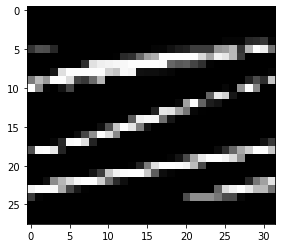

In [32]:
import glob

def load_images(count=1, path=".", extension='*.bmp'):
    """
    loads images as np arrays; no normalization
    """
    imgs =  []
    files = glob.glob(path + "/" + extension)
    for i, f in enumerate(files):
        img = np.asarray(PIL.Image.open(f))
        imgs.append(img)

        if i+1 > count:
            break

    return imgs


import matplotlib.pyplot as plt
import matplotlib
imgs = load_images(count=10,path=quant_image_path)

plt.imshow(imgs[0])

model.train()
# for img in imgs[:1]:
#     target = 1
#     optimizer.zero_grad()
#     output = model(imgs[0])
#     loss = F.nll_loss(output, target)
#     loss.backward()
#     optimizer.step()

In [33]:
model.to(device)
# training only 30 epoches
for epoch in range(1):#range(10):
    print('# Epoch {} #'.format(epoch))
    train(model,  device, train_loader, optimizer)
    test(model, device, test_loader)

# Epoch 0 #
 0%  Loss 2.2985942363739014
 1%  Loss 2.334524393081665
 2%  Loss 2.331967353820801
 2%  Loss 2.1803207397460938
 3%  Loss 1.679300308227539
 4%  Loss 0.44350990653038025
 5%  Loss 1.0870174169540405
 6%  Loss 0.44478973746299744
 7%  Loss 0.8185885548591614
 8%  Loss 0.12845294177532196
 8%  Loss 0.3862129747867584
 9%  Loss 0.1309726983308792
10%  Loss 0.2894265949726105
11%  Loss 0.11949855089187622
12%  Loss 0.017776230350136757
12%  Loss 0.5697534680366516
13%  Loss 0.08740135282278061
14%  Loss 0.01684807613492012
15%  Loss 0.008860183879733086
16%  Loss 0.02163112349808216
17%  Loss 0.04798120632767677
18%  Loss 0.10913238674402237
18%  Loss 0.005032853689044714
19%  Loss 0.049494095146656036
20%  Loss 0.031055588275194168
21%  Loss 0.0030853906646370888
22%  Loss 0.001414109137840569
22%  Loss 0.08494926989078522
23%  Loss 0.004967852495610714
24%  Loss 1.1758991479873657
25%  Loss 0.0061455415561795235
26%  Loss 0.5030335187911987
27%  Loss 0.12902528047561646
28%

# Model Save and Test

In [34]:
"""
The main function of this page is to convert pytorch model to onnx model.
Convertion from pytorch model to onnx model is primary so that a critical
problem is caused that Layer name of pytorch model fail to convert to onnx
layer name directly. To solve it, we wrap pytorch model in new wrapper which
multiply bits number and input before computation of each op. Only in this
way can onnx model get bits number of corresponded layer.
"""

class LayernameModuleWrapper(torch.nn.Module):
    def __init__(self, module, module_bits) -> None:
        """
        Parameters
        ----------
        module : torch.nn.Module
            Layer module of pytorch model
        module_bits : int
            Bits width setting for module
        """
        super().__init__()
        self.module = module
        self.module_bits = module_bits

    def forward(self, inputs):
        inputs = inputs*self.module_bits
        inputs = self.module(inputs)
        return inputs

def _setattr(model, name, module):
    """
    Parameters
    ----------
    model : pytorch model
        The model to speedup by quantization
    name : str
        name of pytorch module
    module : torch.nn.Module
        Layer module of pytorch model
    """
    name_list = name.split(".")
    for name in name_list[:-1]:
        model = getattr(model, name)
    setattr(model, name_list[-1], module)

def unwrapper(model_onnx, index2name, config):
    """
    Fill onnx config and remove wrapper node in onnx
    Parameters
    ----------
    model_onnx : onnx model
        Onnx model which is converted from pytorch model
    index2name : dict
        Dictionary of layer index and name
    config : dict
        Config recording name of layers and calibration parameters
    Returns
    -------
    onnx model
        Onnx model which is converted from pytorch model
    dict
        The configuration of onnx model layers and calibration parameters
    """
    # Support Gemm, Conv, Relu, Clip(Relu6) and Maxpool
    support_op = ['Gemm', 'Conv', 'Relu', 'Clip', 'MaxP']
    idx = 0
    onnx_config = {}
    while idx < len(model_onnx.graph.node):
        nd = model_onnx.graph.node[idx]
        if nd.name[0:4] in support_op and  idx > 1:
            # Grad constant node and multiply node
            const_nd = model_onnx.graph.node[idx-2]
            mul_nd = model_onnx.graph.node[idx-1]
            # Get index number which is transferred by constant node
            index = int(onnx.numpy_helper.to_array(const_nd.attribute[0].t))
            if index != -1:
                name = index2name[index]
                onnx_config[nd.name] = config[name]
            nd.input[0] = mul_nd.input[0]
            # Remove constant node and multiply node
            model_onnx.graph.node.remove(const_nd)
            model_onnx.graph.node.remove(mul_nd)
            idx = idx-2
        idx = idx+1
    return model_onnx, onnx_config

def torch_to_onnx(model, input_shape, model_path, input_names, output_names):
    """
    Convert torch model to onnx model and get layer bits config of onnx model.
    Parameters
    ----------
    model : pytorch model
        The model to speedup by quantization
    config : dict
        Config recording bits number and name of layers
    input_shape : tuple
        The input shape of model, shall pass it to torch.onnx.export
    model_path : str
        The path user want to store onnx model which is converted from pytorch model
    input_names : list
        Input name of onnx model providing for torch.onnx.export to generate onnx model
    output_name : list
        Output name of onnx model providing for torch.onnx.export to generate onnx model
    Returns
    -------
    onnx model
        Onnx model which is converted from pytorch model
    dict
        The configuration of onnx model layers and calibration parameters
    """
    # Convert torch model to onnx model and save it in model_path
    dummy_input = torch.randn(input_shape)
    model.to('cpu')
    torch.onnx.export(model, dummy_input, model_path, verbose=False, input_names=input_names, output_names=output_names, export_params=True)

    # Load onnx model
    model_onnx = onnx.load(model_path)
    model_onnx, onnx_config = unwrapper(model_onnx, index2name, config)
    onnx.save(model_onnx, model_path)

    onnx.checker.check_model(model_onnx)
    return model_onnx, onnx_config



def export_model_to_onnx(model, input_shape=(1,3,imgSizeX,imgSizeY), path=model_name+".onnx"):

    dummy_input = torch.randn(input_shape)
    model.to('cpu')
        
    # very important or must leave out - not sure need to test again...
    #traced = torch.jit.trace(model, input_dimension)
    print("------------- Exporting to onnx")
    torch.onnx.export(
                      model, 
                      dummy_input, 
                      path,
                      opset_version=7,
                      verbose=True,
                      export_params=True, 
                      input_names=['input'],
                      output_names=['output'],
                      dynamic_axes=None
    )
    
    print("------------- Checking exported model")
    
    # Load the ONNX model
    onnx_model = onnx.load(path)

    # Check that the IR is well formed
    onnx.checker.check_model(onnx_model)

    # Print a Human readable representation of the graph
    #print( onnx.helper.printable_graph(onnx_model.graph) )



In [35]:
#export_model_to_onnx(model)

Create a image dimensions configuration file

In [36]:
with open(network_path+"/"+"imgSize.config", 'w') as f:
    f.write('imgSize=%d,%d,%d'%(gen_img_input_channels,imgSizeX,imgSizeY))

In [37]:
from re import L
import subprocess
from subprocess import DEVNULL, STDOUT
from xmlrpc.client import boolean
import pandas as pd
import numpy as np

def parse_the_results(inp="model_execution.log",
                      out="model_execution_parsed.log",
                      script="parse.sh",
                      loop=1,
                      show=False):
    """
    parse the output of the profiled log
    Parameters
    ----------
    inp : input file
        file to be parsed
    out : output file
        the output parsed file
    scripts : parsing scripts
        shell scripts to be used for parsing
    loop: number of runs
        the loops to run the model in the main.c
    show: show the scripts output
        to sohw or hide the shell script output
    Returns
    -------
    None
    """
    if show == False:
        subprocess.check_call([script, inp, out,loop], stdout=DEVNULL, stderr=STDOUT)
    else:
        subprocess.check_call([script, inp, out,loop])

def run_profiler(script=script_path+"/"+"perform.sh",loop=1,test_input="test.jpg",lgofile="model_execution_parsed.log",show=False):
    """
    profile the model
    Parameters
    ----------
    scripts : parsing scripts
        shell scripts to be used for parsing
    loop: number of runs
        the loops to run the model in the main.c
    show: show the scripts output
        to sohw or hide the shell script output
    Returns
    -------
    None
    """
    if show == False:
        subprocess.check_call([script, loop, test_input,lgofile], stdout=DEVNULL, stderr=STDOUT)
    else:
        subprocess.check_call([script, loop, test_input,lgofile])



def auto_profile(model,
                 loop=1,
                 imgChannel=3,
                 imgDimX=28,
                 imgDimY=28,
                 modelwithPath=model_name+".onnx",
                 testingInput="../convertdemo/dataset/mnist2.jpg",
                 performScript = script_path+"/"+"perform.sh",
                 parseScript = script_path+"/"+"parse.sh",
                 performLogFile = log_path+"/"+"model_execution.log",
                 parsedLogFile = log_path+"/"+"model_execution_parsed.log",
                 debug=False):
    """
    Convert torch model to onnx model and get layer bits config of onnx model.
    Parameters
    ----------
    model : pytorch model
        The model to speedup by quantization
    loop : loop
        the number of loops to run the model on khadas in main.c
    debug : show debugging
        show the debugging output of the scripts
    Returns
    -------
    pandas frame
        contains the execution times (profiled time)
    status
        the error flag indicating the status
    """
    profilingDone = False;
    export_model_to_onnx(model,input_shape=(1,imgChannel,imgDimX,imgDimY), path=modelwithPath)

    #sajjad@teco:~/sajjad/scripts/notebook$ ../scripts/perform_r6.sh 10 ../convertdemo/dataset/mnist2.jpg ../logs/model_execution.log
    run_profiler(performScript,loop,testingInput,performLogFile,debug)

    parse_the_results(performLogFile,parsedLogFile,parseScript,loop,debug)

    #read the results into the pandas
    profiledFrames=pd.read_csv(parsedLogFile, sep=':',header = None)

    profilingDone = True;
    return profiledFrames,profilingDone



In [38]:

loop_run = '10'
show_output = False
show_output = True

perform_script_abs = script_path+"/"+perform_script
parse_script_abs = script_path+"/"+parse_script
perform_log_file_abs = log_path+"/"+perform_log_file
parsed_log_file_abs = log_path+"/"+parsed_log_file
model_with_Path = network_path+"/"+model_name+".onnx"


[ProfileArray,status] = auto_profile(model,
                        loop_run,
                        gen_img_input_channels,
                        imgSizeX,
                        imgSizeY,
                        model_with_Path,
                        test_input_data,
                        perform_script_abs,
                        parse_script_abs,
                        perform_log_file_abs,
                        parsed_log_file_abs,
                        show_output)

accData=ProfileArray.values.tolist()

------------- Exporting to onnx
graph(%input : Float(1, 3, 32, 28, strides=[2688, 896, 28, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(20, 3, 5, 5, strides=[75, 25, 5, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(20, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(20, 20, 5, 5, strides=[500, 25, 5, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(20, strides=[1], requires_grad=1, device=cpu),
      %conv3.weight : Float(50, 20, 1, 1, strides=[20, 1, 1, 1], requires_grad=1, device=cpu),
      %conv3.bias : Float(50, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(500, 1000, strides=[1000, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(500, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(10, 500, strides=[500, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %11 : Float(1, 20, 28, 24, strides=[13440, 672, 24, 1]

the input device is not a TTY


>>>>> Creating Remote NBG Directory Done! <<<<<<<
>>>>> Copying C,H & NB files to Remote NBG Directory... <<<<<<<
>>>>> Copying C,H & NB files to Remote NBG Directory Done! <<<<<<<
>>>>> Copying Template Makefile & Build files to Remote NBG Directory... <<<<<<<
>>>>> Copying Template Makefile & Build files to Remote NBG Directory Done! <<<<<<<
patching file main.c
>>>>> Patching main.c on Remote NBG Directory Done! <<<<<<<
>>>>> Compiling the model on Remote Khadas... <<<<<<<
  COMPILE /home/khadas/nbg_unify_mnist/vnn_pre_process.c
  COMPILE /home/khadas/nbg_unify_mnist/vnn_mnist.c


vnn_mnist.c: In function ‘vnn_CreateMnist’:
vnn_mnist.c:146:29: warning: unused variable ‘data’ [-Wunused-variable]
  146 |     uint8_t *               data;
      |                             ^~~~
At top level:
vnn_mnist.c:94:17: warning: ‘load_data’ defined but not used [-Wunused-function]
   94 | static uint8_t* load_data
      |                 ^~~~~~~~~


  COMPILE /home/khadas/nbg_unify_mnist/main.c
  COMPILE /home/khadas/nbg_unify_mnist/vnn_post_process.c
make: Nothing to be done for 'all'.
>>>>> Compiling the model on Remote Khadas Done! <<<<<<<
>>>>> Copying test input image to Remote... <<<<<<<
>>>>> Copying test input image to Remote! <<<<<<<
>>>>> Executing the model on Remote Khadas... <<<<<<<
>>>>> Executing the model on Remote Khadas Done! <<<<<<<
>>>>> Executing network on Khadas is saved in model_execution.log <<<<<<<
Parsing ../logs/model_execution.log....


In [39]:
C0 = np.array(ProfileArray[0])
C1 = np.array(ProfileArray[1])
print('---------\n')
print(C0)
print('---------\n')
print(C1)
print('---------\n')
print(status)

---------

['Create Neural Network' 'Verify Graph' 'Run the 1 time' 'Run the 2 time'
 'Run the 3 time' 'Run the 4 time' 'Run the 5 time' 'Run the 6 time'
 'Run the 7 time' 'Run the 8 time' 'Run the 9 time' 'Run the 10 time'
 'Total   ' 'Average ']
---------

[' 110402us' ' 6251us' ' 18091.00us' ' 220.00us' ' 183.00us' ' 176.00us'
 ' 181.00us' ' 175.00us' ' 175.00us' ' 177.00us' ' 175.00us' ' 178.00us'
 ' 19862.00us' ' 1986.20us']
---------

True
